In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 20.8 MB/s eta 0:00:00


In [ ]:
import os, requests, tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import requests
import seaborn as sns
import copy
from collections import Counter
# Necessary for visualization
from nilearn import plotting, datasets

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
fnames = ["hcp_covariates.tgz",
          "atlas.npz",
          "hcp_task.tgz"]

urls = ["https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download",
        "https://osf.io/2y3fw/download"]

for fname, url in zip(fnames, urls):
    if not os.path.isfile(fname):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                print(f"Downloading {fname}...")
                with open(fname, "wb") as fid:
                    fid.write(r.content)
                    print(f"Download {fname} completed!")

Download hcp_covariates.tgz completed!
Download atlas.npz completed!
Download hcp_task.tgz completed!


In [ ]:
with tarfile.open("hcp_covariates.tgz") as tfile:
    tfile.extractall(".")
with tarfile.open("hcp_task.tgz") as tfile:
    tfile.extractall(".")
with np.load("atlas.npz") as dobj:
    atlas = dict(**dobj)

In [ ]:
print(atlas)

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# Path to the data
HCP_DIR = "./hcp_task"

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

In [ ]:
subjects = np.loadtxt(os.path.join(HCP_DIR, "subjects_list.txt"))
subjects = subjects.astype(int)
regions = np.load(os.path.join(HCP_DIR, 'regions.npy')).T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [ ]:
print("The number of subjects are {}".format(len(subjects)) +
      ", and the avialable information regarding the regions of the brain are:", list(region_info.keys()))
print(f"\nThe number of available networks are: {len(Counter(list(region_info.values())[1]))} \n\n",
      Counter(list(region_info.values())[1]))

### Exploring and cleaning the data

Helper functions to get timeseries BOLD signal for single subject and single run

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Args:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

    Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values
    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
        subject (str): subject ID to load
        experiment (str) : Name of experiment
        run (int): 0 or 1

    Returns
        evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)

        frames = []
        for index, _ in enumerate(start):
            _start = start[index]

            # HACK: Forces all block to be 15 frames in length. In reality all but the last are 25 frames.
            _duration =  15 # duration[index]

            _frames = list(range(_start, _start + _duration))
            frames.append(_frames)

        frames_list.append(frames)

    return frames_list

Example run

In [ ]:
my_exp = 'GAMBLING'
my_subj = subjects[13]  # Assuming subjects is a list of subject IDs
my_run = 0

# Load BOLD signals for a single subject and run for GAMBLING experiment
data = load_single_timeseries(subject=my_subj, experiment=my_exp, run=my_run, remove_mean=True)

# Load EVs (explanatory variables) for the GAMBLING experiment
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

# Print information
print("Shape of BOLD data:", data.shape)
print("Loss EVs:", evs[0])
print("Win EVs:", evs[1])

In [ ]:
#def average_frames(data, evs, experiment, cond):
#    idx = EXPERIMENTS[experiment]['cond'].index(cond)
#    return np.mean(data[:, evs[idx]], axis=1)

def average_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([data[:, evs[idx][i]] for i in range(len(evs[idx]))], axis=-1), axis=-1)


# Assuming 'data' and 'evs' are already defined for the GAMBLING experiment
loss_activity = average_frames(data, evs, 'GAMBLING', 'loss')
win_activity = average_frames(data, evs, 'GAMBLING', 'win')
contrast = win_activity - loss_activity  # difference between win and loss activity


In [ ]:
# Plot activity level in each ROI for both conditions
plt.figure(figsize=(14, 8))
plt.plot(loss_activity, label='loss', color='blue')
plt.plot(win_activity, label='win', color='red')
plt.xlabel('ROI')
plt.ylabel('Activity Level')
plt.title('BOLD Signal Activity Levels for GAMBLING Experiment')
plt.legend()
plt.show()

In [ ]:
# Creating DataFrame for gambling experiment
df_gambling = pd.DataFrame({
    'loss_activity': loss_activity,
    'win_activity': win_activity,
    'regions': region_info['name'],
    'network': region_info['network'],
    'hemi': region_info['hemi']
})

# Plotting activities within brain networks and regions for gambling
fig, axes = plt.subplots(2, 2, figsize=(10, 20), height_ratios=[1, 6])
sns.barplot(y='network', x='loss_activity', data=df_gambling, hue='hemi', ax=axes[0, 0])
sns.barplot(y='network', x='win_activity', data=df_gambling, hue='hemi', ax=axes[0, 1])
sns.barplot(y='regions', x='loss_activity', data=df_gambling, hue='hemi', ax=axes[1, 0])
sns.barplot(y='regions', x='win_activity', data=df_gambling, hue='hemi', ax=axes[1, 1])
axes[1, 1].tick_params(axis='y', labelsize=6)
axes[1, 0].tick_params(axis='y', labelsize=6)
plt.show()


# Loading Timeseries for Individuals and Performing

 Subtraction Analysis for Hemispheres

In [ ]:
timeseries_gambling = []
for subject in subjects:
    ts_concat = load_single_timeseries(subject=subject,
                                       experiment='GAMBLING',
                                       run=my_run,
                                       remove_mean=True)
    timeseries_gambling.append(ts_concat)
print(np.array(timeseries_gambling).shape)


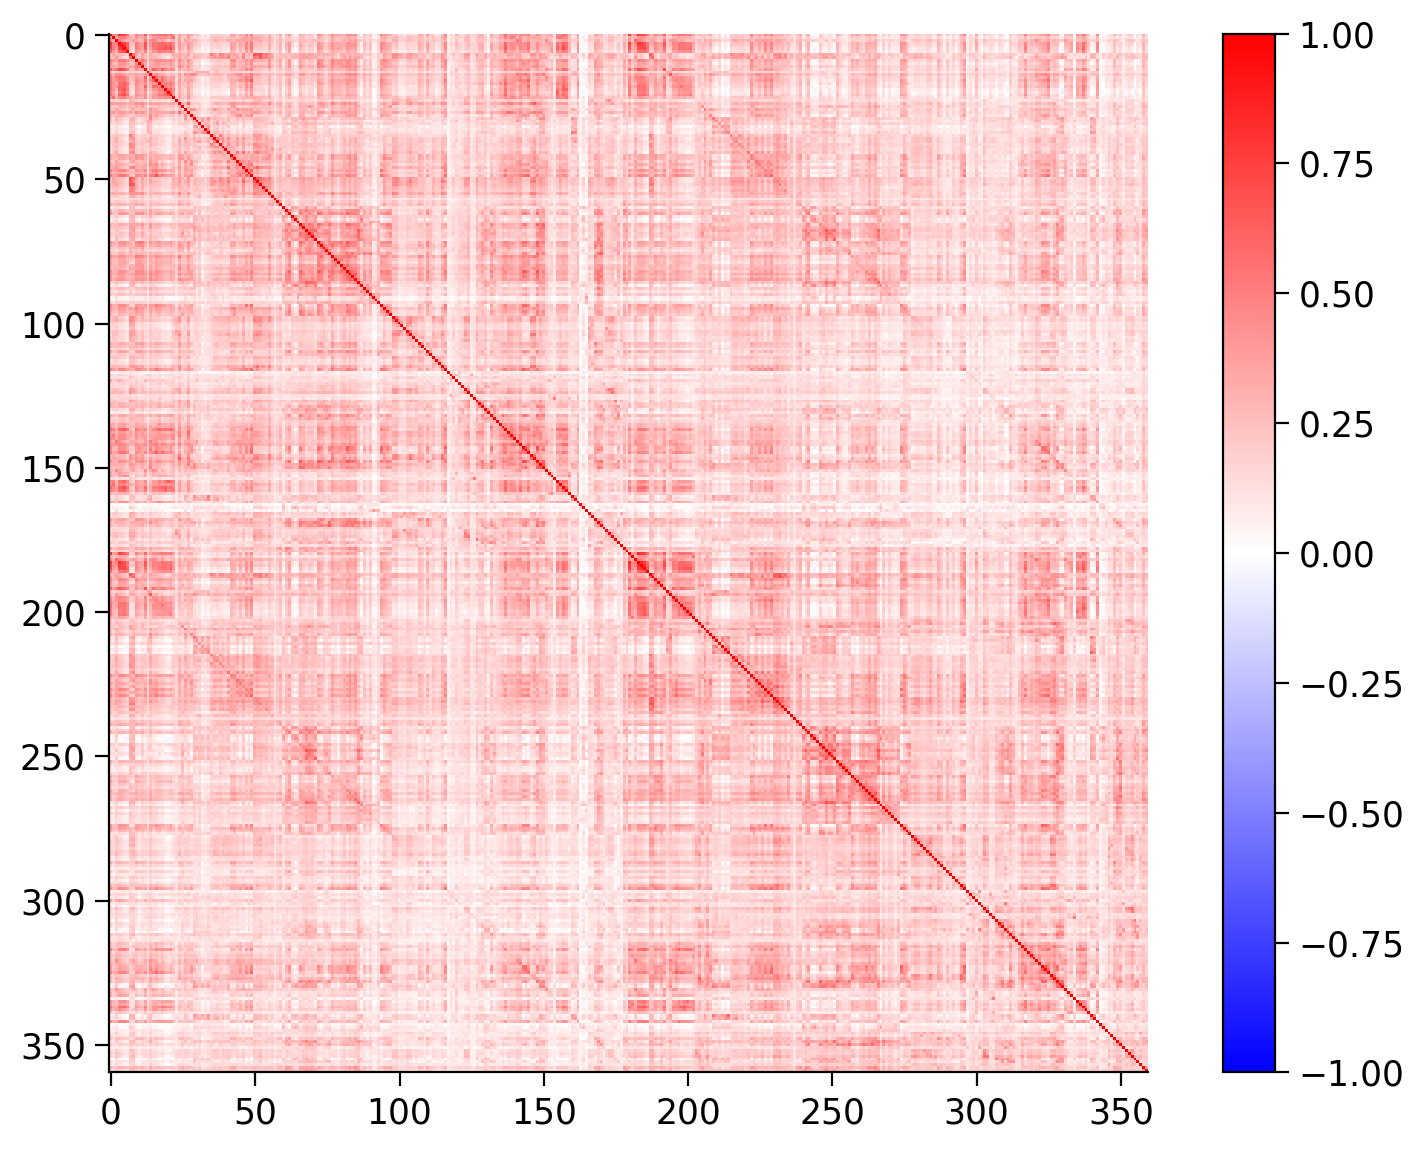

In [ ]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_gambling):
    fc[sub] = np.corrcoef(ts)
# Getting the mean of the ocrrelation coefficients within all subjects
group_fc = fc.mean(axis=0)

plt.figure()
plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
plotting.view_connectome(group_fc, atlas["coords"], edge_threshold="99%")

A simple subtraction analysis

In [ ]:
# Initialize an empty list to store contrasts
contrast = []

# Specify the experiment and conditions
task = "GAMBLING"
conditions = EXPERIMENTS[task]["cond"]

# Loop through each subject
for subject in subjects:
    # Load timeseries and EVs for the subject and experiment
    data = load_single_timeseries(subject=subject, experiment=task, run=my_run, remove_mean=True)
    evs = load_evs(subject=subject, experiment=task, run=my_run)

    # Get the average signal in each region for each condition
    loss_activity = average_frames(data, evs, task, conditions[0])
    win_activity = average_frames(data, evs, task, conditions[1])

    # Calculate the contrast (difference between win and loss activity)
    contrast.append(win_activity - loss_activity)


Plotting group-averaged contrast value across regions

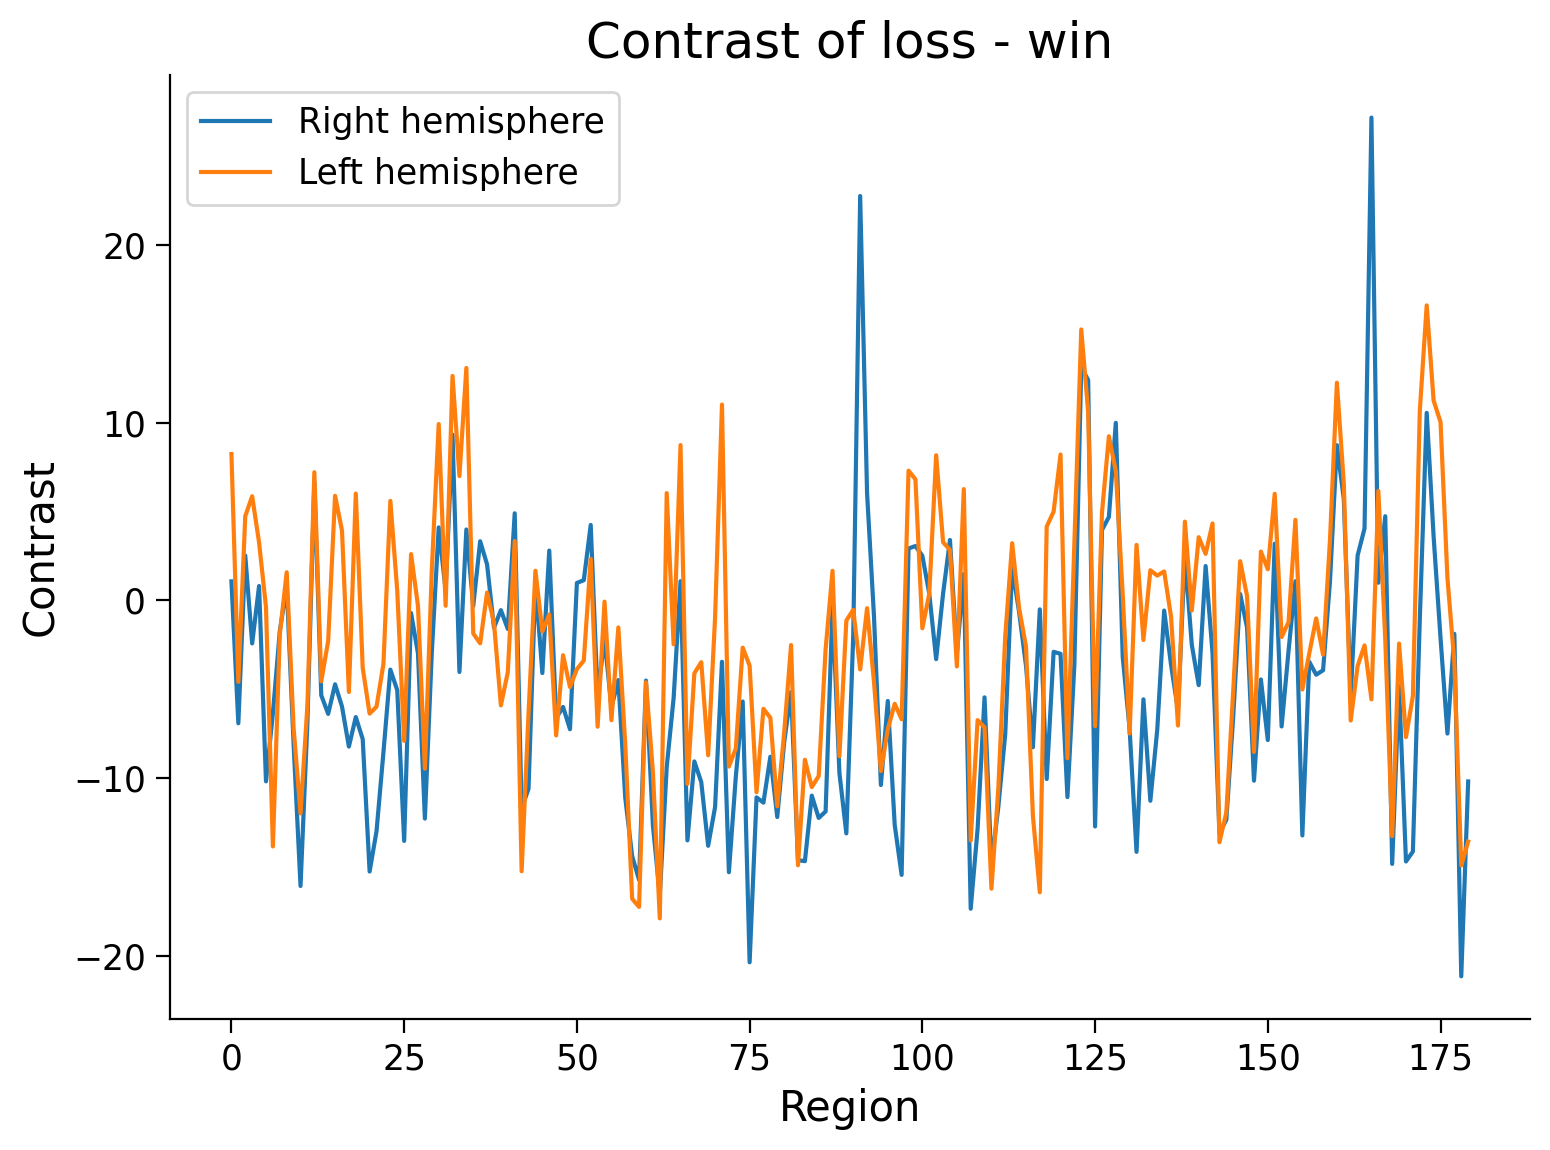

In [ ]:
hemi_contrasts = np.split(np.mean(contrast, axis=0), 2)

plt.figure()
for i, hemi_contrast in enumerate(hemi_contrasts):
    plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.xlabel("Region")
plt.ylabel("Contrast")
plt.legend()
plt.show()

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = np.mean(contrast, axis=0)[atlas["labels_L"]]

plotting.view_surf(fsaverage['infl_left'], surf_contrast, vmax=None)


Demonstrating values by functional networks

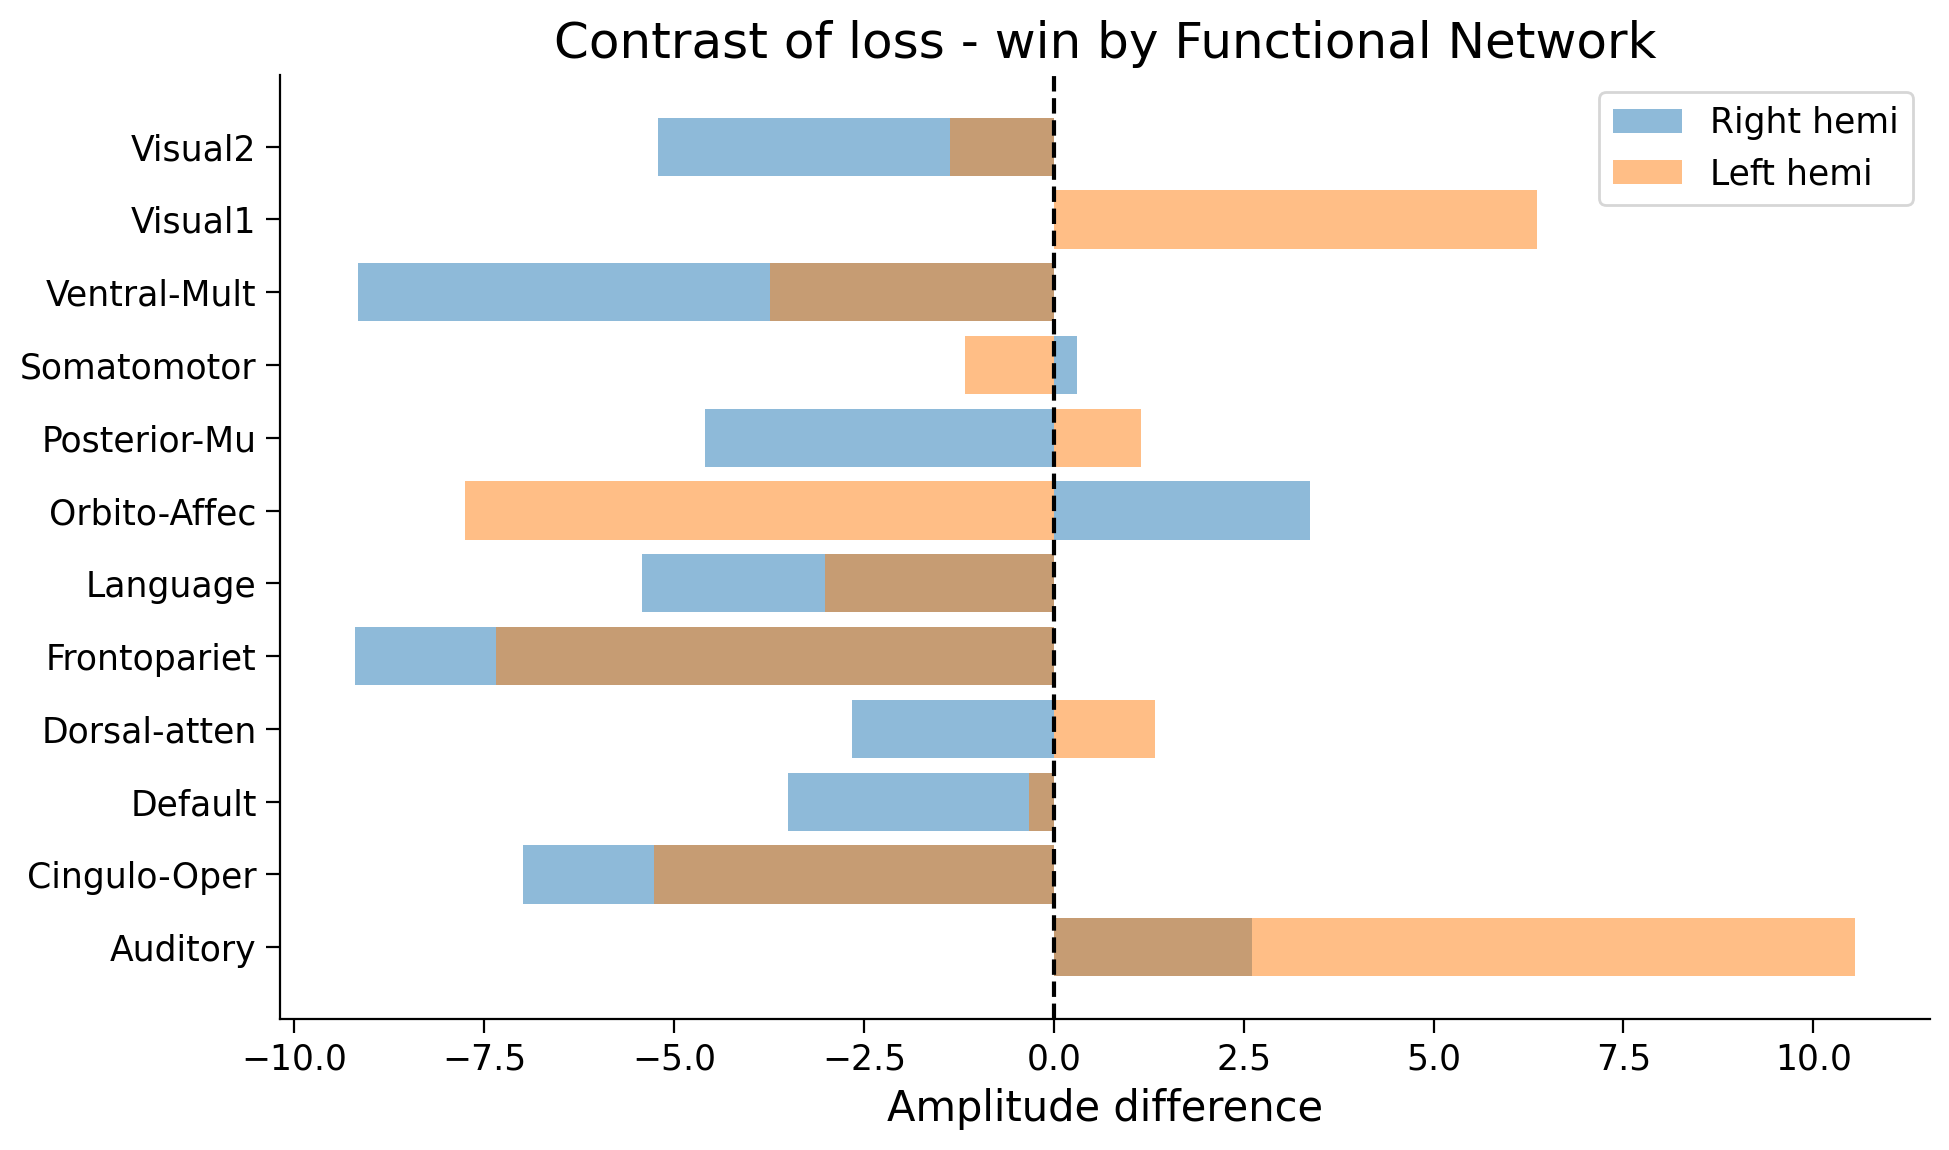

In [ ]:
# Get unique network labels
net_names = np.unique(region_info["network"])

# Split hemisphere data
hemi_nets = np.split(region_info["network"], 2)
hemi_contrasts = np.split(np.mean(contrast, axis=0), 2)

plt.figure(figsize=(10, 6))

# Plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_nets, hemi_contrasts):
    network_vals = []
    for network in net_names:
        network_vals.append(hemi_contrast[hemi_network == network].mean())
    plt.barh(net_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]} by Functional Network")
plt.legend()
plt.tight_layout()
plt.show()


# 5. Devoloping the Models and Performing Analyses for BOLD Signals of Parcels

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import time

In [ ]:
x_tot = []
y_tot = []

for i in range(len(subjects)):
    df = load_single_timeseries(subject=subjects[i],
                                experiment='GAMBLING',  # Adjusted to 'gambling' instead of my_exp
                                run=my_run,
                                remove_mean=True)

    evs = load_evs(subject=subjects[i], experiment='GAMBLING', run=my_run)  # Adjusted to 'gambling' instead of my_exp

    # Assuming 'Win' and 'Loss' are conditions in your 'gambling' experiment
    win_activity = average_frames(df, evs, 'GAMBLING', 'win')
    loss_activity = average_frames(df, evs, 'GAMBLING', 'loss')

    x_tot.append(win_activity)
    y_tot.append(1)
    x_tot.append(loss_activity)
    y_tot.append(0)


In [ ]:
X = np.array(x_tot)
y = np.array(y_tot)
print(X.shape, y.shape)

(200, 360) (200,)


Splitting the data into train and test sets

In [ ]:
# Assuming 'X' is our feature array with shape (200, 360)
# Assuming 'y' is our label array with shape (200,)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

Predicting the win or loss tasks based on parcels BOLD signals
Here I wanted to predict whether the participant have observed win or loss.

Defining, fitting, and evaluating SVM classifier mode

In [ ]:
# Create and train the SVC classifier
start_time = time.time()
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Training time: 0.013175010681152344 seconds


In [ ]:
# Make predictions on test set
y_pred = svm_classifier.predict(X_test)

In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.925


In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
scores = cross_val_score(svm_classifier, X, y, cv=kf)
print("Cross-validation scores:", scores)
print("Average accuracy:", np.mean(scores))

Cross-validation scores: [0.925 0.9   0.925 0.9   0.95 ]
Average accuracy: 0.9199999999999999


Now I choose the most important features in the model

In [ ]:
feature_weights = svm_classifier.coef_[0]
feature_weights_list = list(enumerate(feature_weights))
feature_names = region_info["name"]

In [ ]:
#Create a list of tuples containing feature indices and corresponding weights
feature_weights_list = list(enumerate(feature_weights))
feature_name_list = [feature_weights_list[i] + (feature_names[i],) for i in range(len(feature_weights_list))]
# Sort the feature weights in descending order of absolute values
sorted_feature_weights = sorted(feature_name_list, key=lambda x: abs(x[1]), reverse = True)
top_10_features = sorted_feature_weights[:10]

In [ ]:
top_feature_indices = []
top_feature_names = []
top_feature_weights = []
for i in range(len(top_10_features)):
    top_feature_indices.append(top_10_features[i][0])
    top_feature_weights.append(top_10_features[i][1])
    top_feature_names.append(top_10_features[i][2])

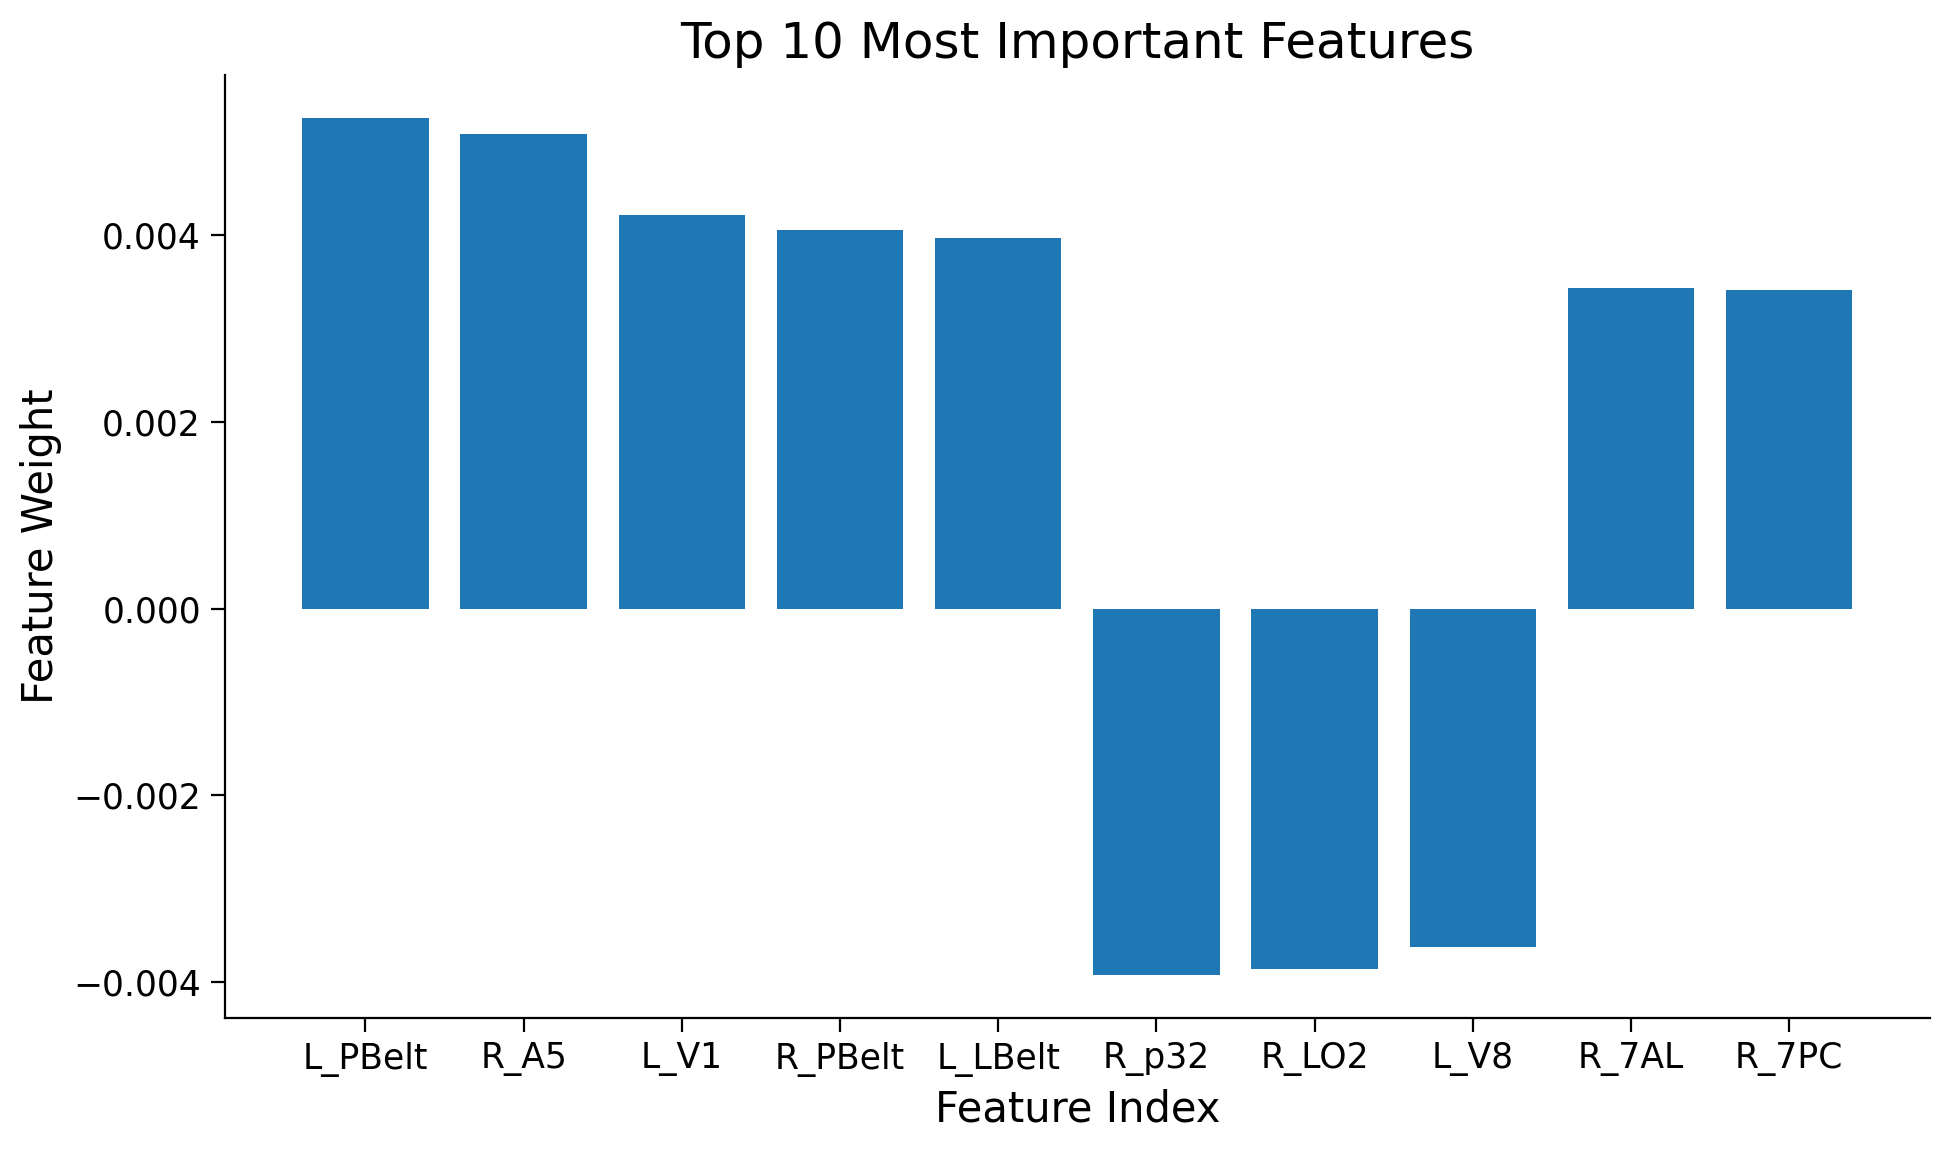

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_names)), top_feature_weights, align='center')
plt.xticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Index')
plt.ylabel('Feature Weight')
plt.title('Top 10 Most Important Features')
plt.show()

Training the model on the ten most important features

In [ ]:
X_ten = X[:, top_feature_indices]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ten, y, test_size=0.2, random_state = 42)

In [ ]:
# Create and train the SVC classifier
start_time = time.time()
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Training time: 0.9066009521484375 seconds


In [ ]:
# Make predictions on test set
y_pred = svm_classifier.predict(X_test)

In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.725


using XGBoost

In [ ]:
# Create and train the XGBoost classifier
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification tasks
    learning_rate=0.1,            # Learning rate (step size) for boosting process
    max_depth=3,                  # Maximum depth of each tree
    n_estimators=100,             # Number of boosting rounds (trees)
    random_state=42               # Set a random seed for reproducibility
)

xgb_classifier.fit(X_train, y_train)  # Training the classifier

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.75
